<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Code-setup" data-toc-modified-id="Code-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Code setup</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Read-items-from-ENM-preprocessing" data-toc-modified-id="Read-items-from-ENM-preprocessing-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Read items from ENM preprocessing</a></span></li><li><span><a href="#Read-organics-data" data-toc-modified-id="Read-organics-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Read organics data</a></span></li><li><span><a href="#Imputation-for-log(density)" data-toc-modified-id="Imputation-for-log(density)-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Imputation for log(density)</a></span></li><li><span><a href="#Organics-dataframes" data-toc-modified-id="Organics-dataframes-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Organics dataframes</a></span></li><li><span><a href="#Organics-WF-bins" data-toc-modified-id="Organics-WF-bins-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Organics WF bins</a></span></li></ul></li><li><span><a href="#Pre-processing" data-toc-modified-id="Pre-processing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pre-processing</a></span><ul class="toc-item"><li><span><a href="#Data-distributions" data-toc-modified-id="Data-distributions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data distributions</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#Hierarchical-Agglomerative-Clustering-(HAC)" data-toc-modified-id="Hierarchical-Agglomerative-Clustering-(HAC)-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Hierarchical Agglomerative Clustering (HAC)</a></span></li></ul></li></ul></div>

# Code setup

In [1]:
try:
    %load_ext lab_black
except ModuleNotFoundError:
    print("Couldn't load Black autoformatter.")

In [2]:
# To suppress warning output
import warnings

# warnings.filterwarnings('ignore')
# warnings.simplefilter('ignore')

# Important imports
import numpy as np
from numpy import random
import pandas as pd
import os, sys

# Set random seed across notebook for repeatable results
np.random.seed(1922)

In [50]:
# To plot nice figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
from matplotlib.ticker import MultipleLocator

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["axes.titlesize"] = "x-large"  # 16
plt.rcParams["axes.labelsize"] = "x-large"
plt.rcParams["xtick.labelsize"] = "x-large"
plt.rcParams["ytick.labelsize"] = "x-large"

In [51]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "figs"

if not (os.path.isdir(PROJECT_ROOT_DIR + "/" + PROJECT_SAVE_DIR)):
    print("Figure directory did not exist, creating now.")
    os.mkdir(PROJECT_ROOT_DIR + "/" + PROJECT_SAVE_DIR)
else:
    print("Figure directory exists.")

Figure directory exists.


In [52]:
# Import classes and functions used across multiple notebooks
sys.path.append(os.getcwd())
import importlib
import functions as blt

importlib.reload(blt)

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
Figure directory exists.


<module 'functions' from '/Users/blt/Documents/ml-weight-fraction/functions.py'>

# Data

## Read items from ENM preprocessing

These will be used to help shape the organics data frame.

In [53]:
# Import data frame headings from target model (before pre-processing)
enm_cols = []
with open("./data/column-headers.txt", "r") as filehandle:
    for line in filehandle:
        # Remove linebreak which is the last character of the string
        currentCol = line[:-1]
        # Add item to the list
        enm_cols.append(currentCol)

In [54]:
# Read pre-processed ENM data (before applying feature reduction)
X_enm = pd.read_csv("./data/ENM-preprocessed-feats.csv", sep="\t", index_col=0)
X_enm.head(4)

,cprp_MW,cprp_MP,cprp_BP,cprp_density,func_absorbent,func_antiadhesivecohesive,func_antioxidant,func_antiredepositionagent,func_biocide,func_brightener,...,pgrp_makeuprelated,pgrp_nutritionalsupplements,pgrp_paintstainrelated,pgrp_portableairprocessing,pgrp_sunscreen,pgrp_surfacesealers,pgrp_toys,mtrx_spray,mtrx_formulation,mtrx_WFmeasured
0,79.867,1843.00,2972.0,4.230,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
1,63.546,1083.00,2567.0,8.960,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,1,0
2,65.370,419.53,907.0,7.140,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,107.868,961.78,2162.0,10.345,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


## Read organics data

In [55]:
# Read in organcis potential predictive variables ("features")
X_source = pd.read_csv("./data/organics-clean.csv", sep=",", index_col=0)

# Read in organics weight fraction data
y_source = pd.read_csv("./data/organics-clean.csv", sep=",", usecols=[2])

print([X_source.shape, y_source.shape])

[(29373, 87), (29373, 1)]


In [56]:
# Clean feature data and column names

# Drop unwanted columns (CASRN, WF, product type, chem-props unused in ENM df)
X_source.drop(
    X_source.columns[[0, 1, 4, 8, 9, 10, 11, 14, 15, 17]], axis=1, inplace=True
)

# Rename columns
X_source.columns = X_source.columns.str.replace("_", "")
X_source.rename(
    columns={
        "gencatID": "pgen",
        "group": "pgrp",
        "refinedproducttype": "refined",
        "assignedID": "mtrx",
        "uvstabilizer": "UVstabilizer",
    },
    inplace=True,
)

# Clean up data in refined column so it's only spray vs NOC
X_source.loc[X_source.refined != "spray", "refined"] = "NOC"

# Transform factor data (product categories) into binary columns
X_source = pd.get_dummies(
    X_source,
    prefix=["pgen", "pgrp", "refined", "mtrx"],
    columns=["pgen", "pgrp", "refined", "mtrx"],
)

# Remove spaces from column names
X_source.columns = X_source.columns.str.replace(" ", "")
X_source.columns = X_source.columns.str.replace("/", "")
X_source.columns = X_source.columns.str.replace("-", "")
X_source.columns = X_source.columns.str.replace("and", "")

# Edit column name prefixes and suffixes for consistency and clarity
X_source.columns = X_source.columns.str.replace("Density", "density")
X_source.columns = X_source.columns.str.replace("prop", "cprp_")
X_source.columns = X_source.columns.str.replace("refined", "mtrx")
X_source.columns = X_source.columns.str.replace("mtrx_F", "mtrx_formulation")
X_source.columns = X_source.columns.str.replace("relatedproducts", "related")

# Add 'func' prefix to functional uses
cols = X_source.columns
idx_func = np.asarray([i for i, c in enumerate(cols) if not "_" in c])
X_source.rename(
    columns={c: "_".join(("func", c)) for c in cols[idx_func]}, inplace=True
)

In [57]:
# If there are ENM features not present in organics df, add them

# List differences between feature sets
cols_add = list(set(enm_cols) - set(X_source.columns.tolist()))
# Assign these features to organics df with default values of zero
for col in cols_add:
    X_source[col] = 0

In [58]:
# Delete unwanted samples

# Restructure organics features df to match ENM df
X_source = X_source[enm_cols]
# Temporarily add WF labels to df
X_source = pd.concat([y_source, X_source], axis=1)
# Delete rows that are missing important chemical property data
X_source = X_source[X_source["cprp_MP"].notnull()]
# Remove outlier lacking density data
X_source = X_source[X_source["cprp_MP"] > -170]
# Delete rows that don't have enough data (positive labels)
X_source = X_source[X_source.iloc[:, 5:].sum(axis=1) > 2]
print(X_source.shape)

(16439, 54)


In [59]:
# Extract wf labels (y) from new X_source
y_source = X_source[["maximum_weight_fraction"]]
X_source.drop(X_source.columns[[0]], axis=1, inplace=True)
print(y_source.shape)

(16439, 1)


In [60]:
# Preview final main dataframe
X_source.tail(5)

,cprp_MW,cprp_MP,cprp_BP,cprp_density,func_absorbent,func_antiadhesivecohesive,func_antioxidant,func_antiredepositionagent,func_biocide,func_brightener,...,pgrp_makeuprelated,pgrp_nutritionalsupplements,pgrp_paintstainrelated,pgrp_portableairprocessing,pgrp_sunscreen,pgrp_surfacesealers,pgrp_toys,mtrx_spray,mtrx_formulation,mtrx_WFmeasured
29366,152.149,84.03215,263.941,1.198,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
29367,152.149,84.03215,263.941,1.198,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
29368,152.149,84.03215,263.941,1.198,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
29369,135.210,-31.78080,203.080,0.930,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
29370,135.210,-31.78080,203.080,0.930,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [61]:
y_source.tail(5)

,maximum_weight_fraction
29366,0.01
29367,0.01
29368,0.02
29369,0.02
29370,0.05


## Imputation for density

In [62]:
# How much density data is missing?
print("Missing data dimensions:")
print(X_source[X_source["cprp_density"].isnull()].shape)

# Percent of density data missing
missing_perc = len(X_source[X_source["cprp_density"].isnull()]) / len(X_source)
print("Fraction of density data missing: %.3f" % missing_perc)

Missing data dimensions:
(639, 53)
Fraction of density data missing: 0.039


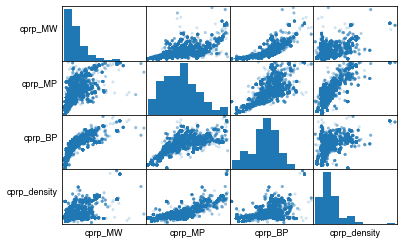

In [63]:
# Look at chemical property features
feat_subset = [f for f in X_source.columns if "cprp" in f]

# Plot scatter matrix and histograms
scatter_mtrx = pd.plotting.scatter_matrix(X_source[feat_subset], alpha=0.2)
plt.xticks([])
plt.yticks([])

for ax in scatter_mtrx.ravel():
    ax.set_xlabel(
        ax.get_xlabel(), fontsize=9, rotation=0,
    )
    ax.set_ylabel(
        ax.get_ylabel(), fontsize=9, rotation=0, horizontalalignment="right",
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

We will use sklearn's $SimpleImputer$ transformer to replace missing values using the *median*. This was selected over a more complex imputer as:

* Only a small percentage of density data is missing (complexity shouldn't affect model performance)
* The data may not be missing at random (density measurements may be harder to obtain for some molecules)
* The distrubution of density data is skewed (thus the median is preferable over the mean)

In [64]:
from sklearn.impute import SimpleImputer

# What is the median?
print("Density median:", X_source["cprp_density"].median())

# Impute
imp_median = SimpleImputer(missing_values=np.nan, strategy="median", copy=False)
imp_median.fit_transform(X_source)

Density median: 0.995


array([[106.168  , -52.5218 , 147.1505 , ...,   0.     ,   1.     ,
          0.     ],
       [106.168  , -52.5218 , 147.1505 , ...,   0.     ,   1.     ,
          0.     ],
       [106.168  , -52.5218 , 147.1505 , ...,   1.     ,   1.     ,
          0.     ],
       ...,
       [152.149  ,  84.03215, 263.941  , ...,   0.     ,   1.     ,
          0.     ],
       [135.21   , -31.7808 , 203.08   , ...,   0.     ,   1.     ,
          0.     ],
       [135.21   , -31.7808 , 203.08   , ...,   0.     ,   1.     ,
          0.     ]])

In [65]:
# How much density data is missing?
print("Missing data dimensions:")
print(X_source[X_source["cprp_density"].isnull()].shape)

Missing data dimensions:
(0, 53)


## Organics WF bins

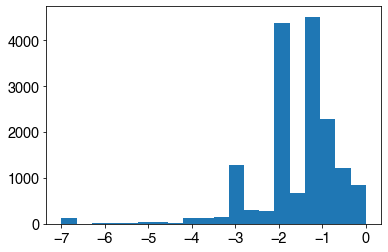

In [66]:
# Log-transformed histogram of weight fraction
fig, ax = plt.subplots()
plt.hist(np.log10(np.asarray(y_source) + 0.0000001), bins=20)
ax.xaxis.set_major_locator(MultipleLocator(1))

In [67]:
# Define function to assign weight fractions to bins per Isaacs et al. 2016
def bins(row):
    if row["maximum_weight_fraction"] <= 0.01:
        val = "bottom"
    elif row["maximum_weight_fraction"] > 0.05:
        val = "top"
    else:
        val = "middle"
    return val


bin_source_isaacs = y_source.apply(bins, axis=1)

Text(0.5, 1.0, 'Frequency of Isaacs et al. Organic Weight Fraction Bins')

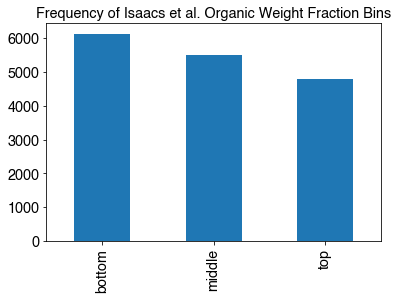

In [68]:
bin_source_isaacs.value_counts()[["bottom", "middle", "top"]].plot(kind="bar")
plt.title("Frequency of Isaacs et al. Organic Weight Fraction Bins")

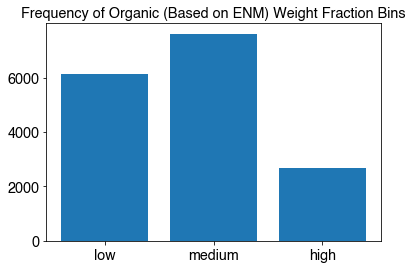

Label bin:  [0 1 2]
Count    :  [6127 7617 2695]
Frequency:  [0.37, 0.46, 0.16]


In [69]:
# Apply bins to organics data
# (slightly different ranges from those used by Isaacs et al. 2016)
bin_source = np.asarray(y_source.apply(blt.bins, axis=1))
# View bar plot of ENM WF bins
blt.bar_graph_bins(bin_source, data_composition="Organic (Based on ENM)")

## Data summaries

In [91]:
# Function for plotting piecharts
def plot_barhgraph(df1, df2, feat_subset_prefix, save_fig_name=None, figsize=[6, 4]):

    # Aesthetic settings
    plt.rcParams["axes.labelsize"] = 12
    plt.rcParams["xtick.labelsize"] = 12
    plt.rcParams["ytick.labelsize"] = 10
    my_colors = [
        "tab:blue",  # sky blue
        "#E59400",  # orange
        "tab:purple",  # purple-blue
        "#C0504D",  # red
        "tab:olive",
        "#323299",  # dark blue
        "#7a307a",  # violet
        "seagreen",
        "sienna",
        "gold",
    ]

    # Define data and labels for plotting
    feat_subset = [f for f in df1.columns if feat_subset_prefix in f]
    v1 = df1[feat_subset].sum(axis=0)
    v2 = df2[feat_subset].sum(axis=0)
    labels = [f.split("_")[1] for f in feat_subset]

    # Plot
    ind = np.arange(len(labels))
    p1 = plt.barh(ind, v1)
    p2 = plt.barh(ind, v2)  # , bottom=v1

    plt.xlabel("Number of Consumer Products with Feature")
    plt.yticks(ind, labels)
    plt.legend((p1[0], p2[0]), ("ENM Products", "Organics Products"))

    # savepdf(fig, "bar_%s" % save_fig_name.lower().replace(" ", "_").replace(")", ""))
    plt.show()

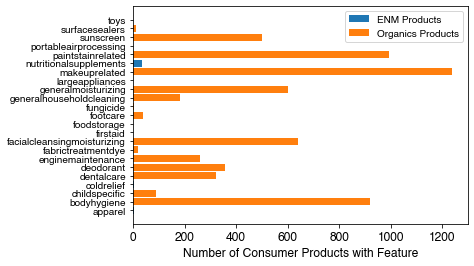

In [92]:
# TODO: fix bar overlay
plot_barhgraph(X_enm, X_source, feat_subset_prefix="pgrp")

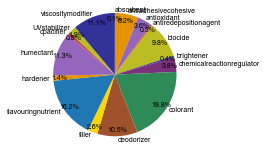

In [93]:
# Organics function breakdown as pie chart
blt.plot_piechart(
    data=X_source,
    feat_subset_prefix="func",
    save_fig_name="b) Organics Functional Uses",
    figsize=[3, 2.5],
    labels=None,
)

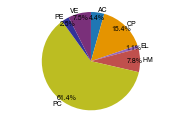

In [94]:
# Organics PUC breakdown as pie chart
blt.plot_piechart(
    data=X_source,
    feat_subset_prefix="pgen",
    save_fig_name="d) Organics General Product Categories",
    figsize=[3, 2],
)

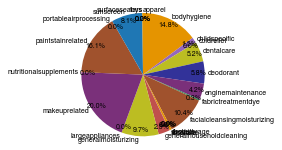

In [95]:
# Organics PUC breakdown as pie chart
blt.plot_piechart(
    data=X_source,
    feat_subset_prefix="pgrp",
    save_fig_name="f) Organics Product Group Categories",
)

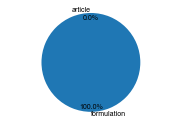

In [96]:
# Organics product matrices as pie chart
blt.plot_piechart(
    data=X_source,
    feat_subset_prefix="mtrx_formulation",
    save_fig_name="g) ENM Product Matrix",
    figsize=[3, 2],
    labels=["formulation", "article"],
)

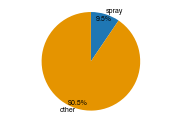

In [97]:
# Organics spray products as pie chart
blt.plot_piechart(
    data=X_source,
    feat_subset_prefix="mtrx_spray",
    save_fig_name="i) ENM Spray Products",
    figsize=[3, 2],
)

# Export data

In [98]:
# Export organics CP dataframe for use in modeling scripts
X_source.to_csv(
    "./data/organics-preprocessed-feats.csv",
    sep="\t",
    na_rep="",
    header=True,
    index=True,
    index_label=None,
    mode="w",
)

In [99]:
# Export organics WF labels
y_source.to_csv(
    "./data/organics-preprocessed-WF.csv",
    sep="\t",
    na_rep="",
    header=True,
    index=True,
    index_label=None,
    mode="w",
)